In [1]:
from scipy.io import loadmat
import numpy as np
import torch
import matplotlib.pyplot as plt
from lift.datasets import compute_features

In [2]:
import sys
sys.path.append('/Users/kilian/dev/LIFT/')

# Reference data

In [3]:
data = loadmat('../datasets/activations/data.mat', squeeze_me=True)
act_ref_emg = data['data']['x'].take(0)
act_ref_labels = data['data']['y'].take(0)

act_ref_features = compute_features(torch.tensor(np.swapaxes(act_ref_emg, 1, 2)))


rest_idx = np.argwhere(act_ref_labels == 11).flatten()
act_ref_rest_features = act_ref_features[rest_idx]
act_ref_mean_rest = act_ref_rest_features.mean(axis=0)

action_idx = np.argwhere(act_ref_labels != 11).flatten()
act_ref_action_features = act_ref_features[action_idx]

label_idx = np.argwhere(act_ref_labels == 3).flatten()
act_ref_label_features = act_ref_features[label_idx]
step_size = act_ref_label_features.shape[0] // 2

n_actions = len(np.unique(act_ref_labels)) - 1

action_feats = act_ref_action_features.chunk(n_actions)

act_ref_high_feats = torch.cat([act_feat[:step_size, :] for act_feat in action_feats])
act_ref_low_feats = torch.cat([act_feat[step_size:, :] for act_feat in action_feats])

- Only MAV and WL change (both change with limit of uniform distribution, thus this should be the only change in raw signal)
- Big signals change more -> make scaling depend on initial value

# MAD data

In [4]:
from configs import BaseConfig
from lift.environments.simulator import WindowSimulator
from lift.datasets import get_mad_windows
import numpy as np

config = BaseConfig()

data_path = (config.mad_data_path / "Female0"/ "training0").as_posix()
mad_windows, mad_labels = get_mad_windows(data_path, 200, 200, desired_labels=[0, 1, 2, 3, 4, 5, 6])
mad_features = compute_features(mad_windows)

sim = WindowSimulator(
    action_size=config.action_size, 
    num_bursts=config.simulator.n_bursts, 
    num_channels=config.n_channels,
    window_size=config.window_size, 
    return_features=True,
    noise=0.01,
)
sim.fit_params_to_mad_sample(
    (config.mad_data_path / "Female0"/ "training0").as_posix()
)

/Users/kilian/dev/lift/lift/datasets.py:109: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  short_labels = torch.tensor([np.repeat(label, repeats=n_repeats) for label in label_list])


In [5]:
mad_labels.unique()

tensor([0, 1, 2, 3, 4, 5, 6])

In [6]:
rest_idx = np.argwhere(mad_labels == 0).flatten()
rest_features = mad_features[rest_idx]
mad_mean_rest = rest_features.mean(axis=0)

action_idx = np.argwhere(mad_labels != 0).flatten()
mad_label_features = mad_features[action_idx]
mad_mean_action = mad_label_features.mean(axis=0)

# SIM

In [7]:
sim_feat_list = []
for _ in range(10):
    action = np.array([[0.0, 0.0, 0.0], [0.3, 0.0, 0.0], [0.5, 0.0, 0.0], [0.7, 0.0, 0.0]])
    action = -action
    sim_feats = sim(action)
    sim_feat_list.append(sim_feats)
sim_feats = np.stack(sim_feat_list)
sim_feats = sim_feats.mean(axis=0)

In [8]:
sim_action_sums = np.abs(action).sum(axis=1)
mean_rest = sim_feats[0]
medium_feat = sim_feats[1]
high_feat = sim_feats[3]
low_feat = sim_feats[2]

# Interpolate MAD samples

In [9]:
from lift.datasets import mad_augmentation, get_mad_windows
from lift.utils import mad_labels_to_actions

mad_windows, mad_labels = get_mad_windows(data_path, 200, 200, desired_labels=[0, 1, 2, 3, 4, 5, 6])

In [10]:
data_path = (config.mad_data_path / "Female0"/ "training0").as_posix()
mad_emg, mad_labels, windows_list, label_list = get_mad_windows(data_path, 
                                                                config.window_size,
                                                                config.window_increment,
                                                                desired_labels=[0, 1, 2, 3, 4, 5, 6],
                                                                return_lists=True)
mad_featuers = compute_features(mad_emg)
actions_list = mad_labels_to_actions(label_list, recording_strength=config.simulator.recording_strength)
mad_actions = mad_labels_to_actions(mad_labels, recording_strength=config.simulator.recording_strength)

sample_emg, sample_actions = mad_augmentation(windows_list, actions_list, 10000)
sample_features = compute_features(sample_emg)

In [11]:
num_augmentation = 100
test_mad_windows = [torch.rand(10,8,200) for _ in range(7)]
test_actions = [torch.rand(3) * 2 - 1 for _ in range(7)]
test_actions[0] = torch.zeros(3)
sample_emg, sample_actions = mad_augmentation(test_mad_windows, test_actions, num_augmentation)
sample_features = compute_features(sample_emg)

sim_sample_features = sim(sample_actions)

In [12]:
action_sums = np.abs(sample_actions).sum(axis=1)

In [13]:
first_bin = np.where(action_sums < 0.3)[0]
second_bin = np.where((action_sums >= 0.3) & (action_sums < 0.6))[0]
third_bin = np.where(action_sums >= 0.6)[0]

mean_first_feats = sample_features[first_bin].mean(axis=0)
mean_second_feats = sample_features[second_bin].mean(axis=0)
mean_third_feats = sample_features[third_bin].mean(axis=0)

sim_mean_first_feats = sim_sample_features[first_bin].mean(axis=0)
sim_mean_second_feats = sim_sample_features[second_bin].mean(axis=0)
sim_mean_third_feats = sim_sample_features[third_bin].mean(axis=0)

first_action_sums = action_sums[first_bin].mean()
second_action_sums = action_sums[second_bin].mean()
third_action_sums = action_sums[third_bin].mean()

In [14]:
import matplotlib.cm as plt_cm
import matplotlib

# cm = plt_cm.rainbow
cm = plt.colormaps.get_cmap('Reds')
normalize = matplotlib.colors.Normalize(vmin=-.5, vmax=2)

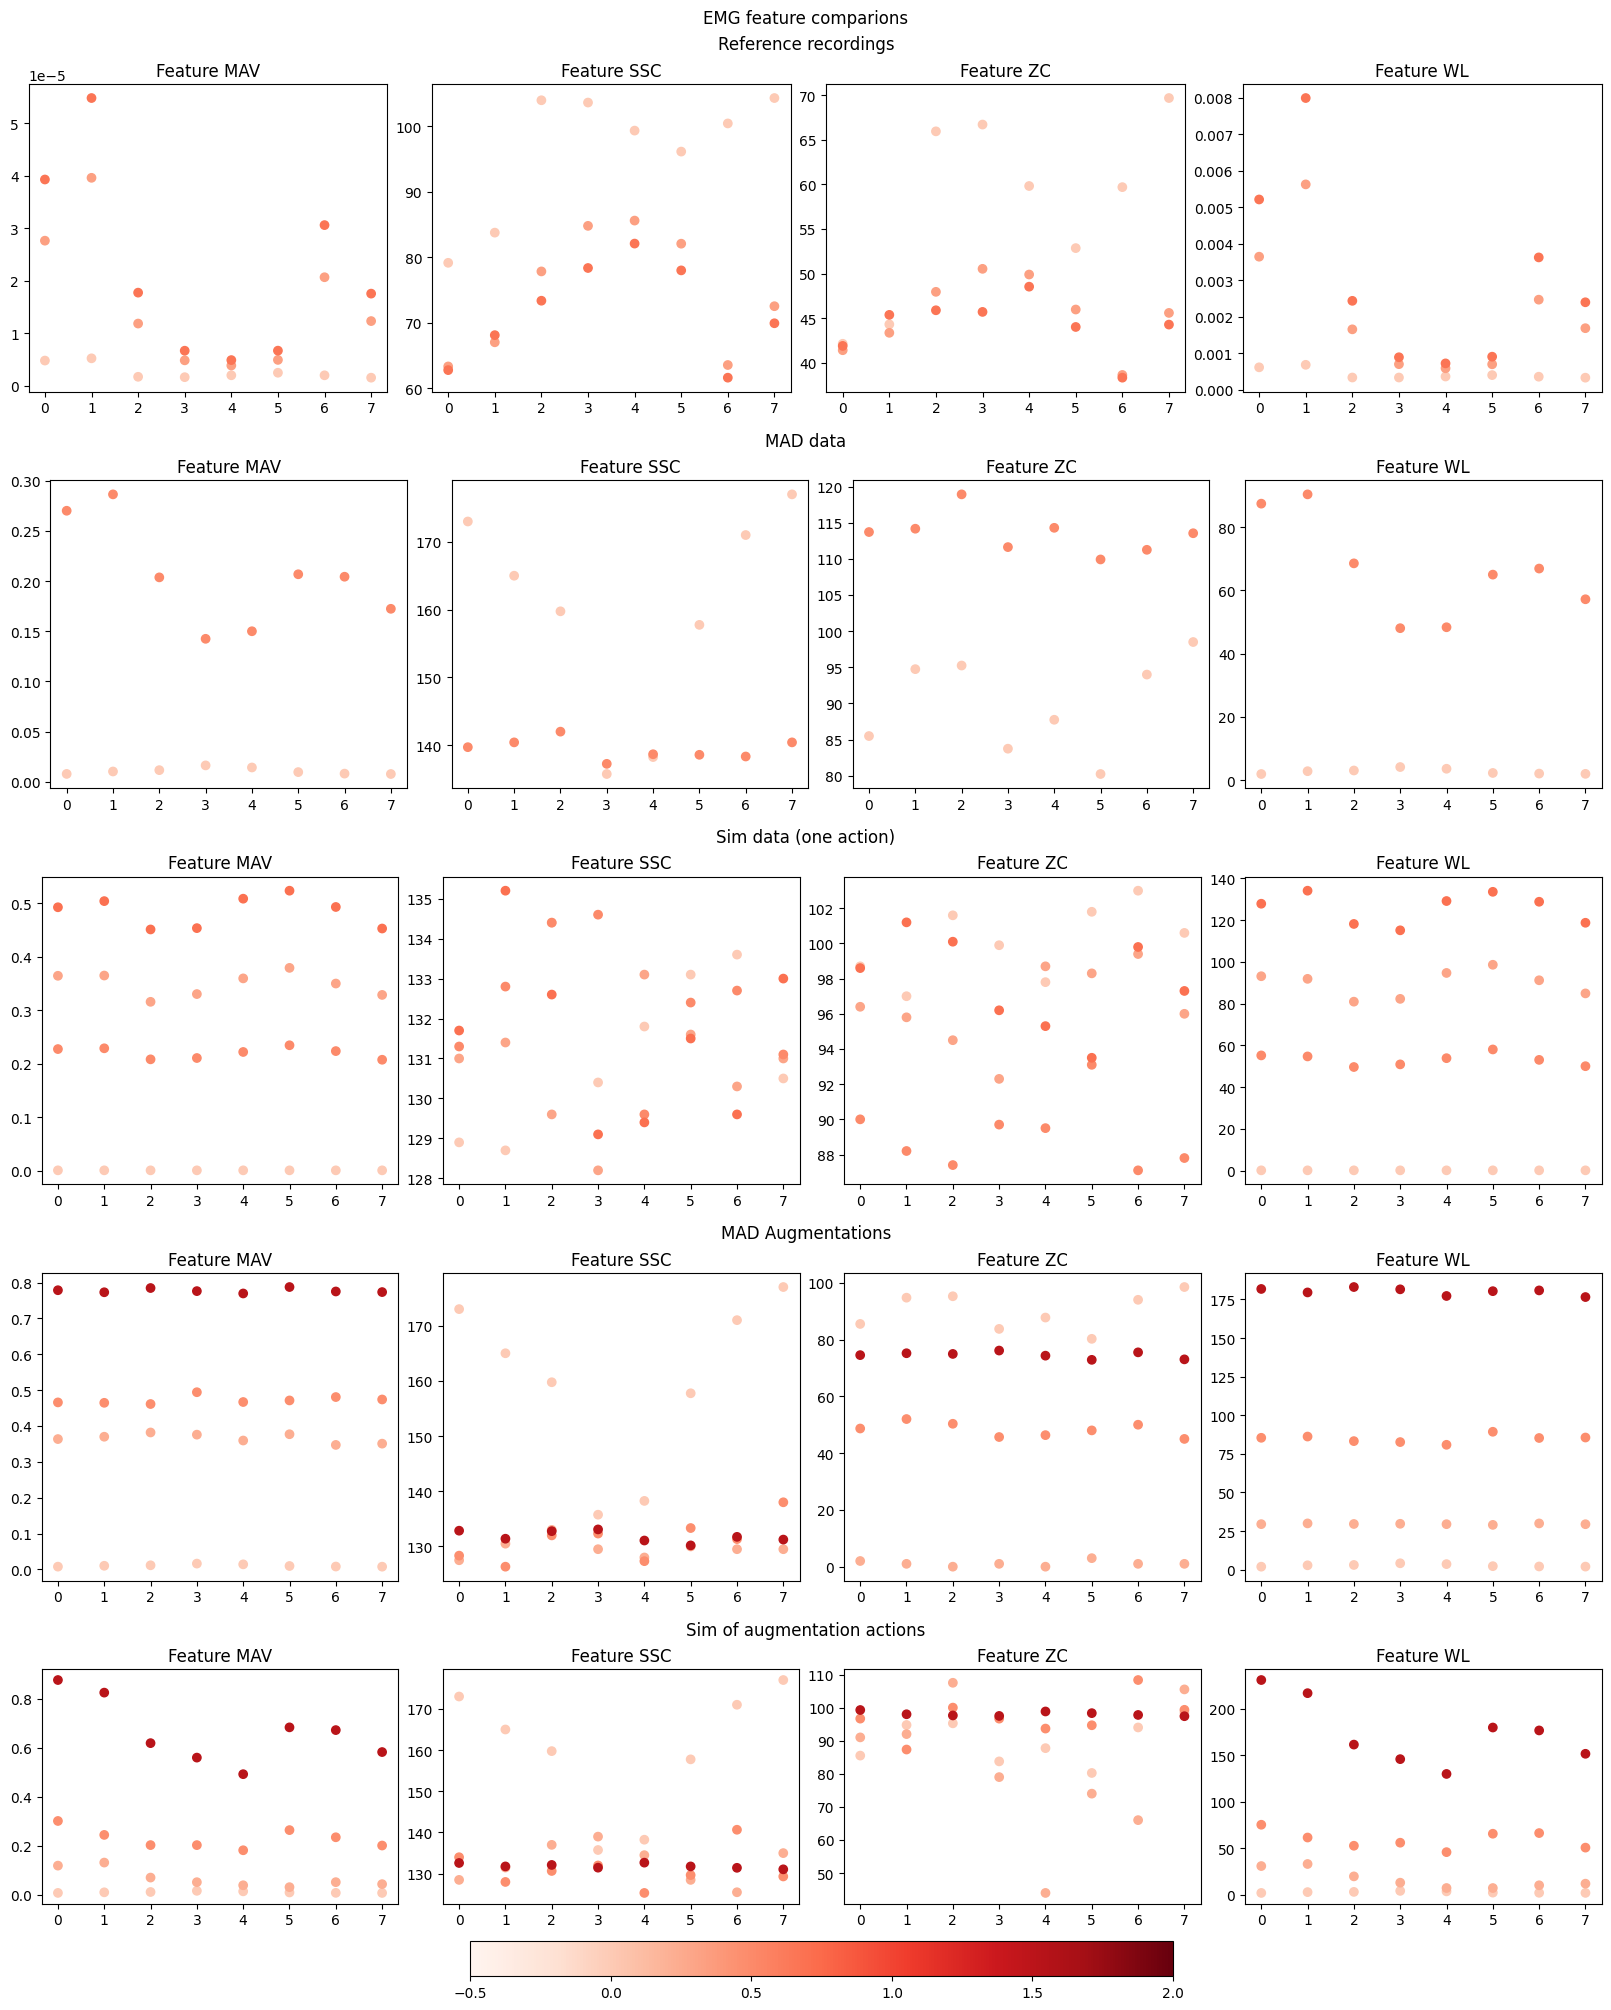

In [15]:
# create 3x1 subplots
fig, axs = plt.subplots(nrows=5, ncols=1, constrained_layout=True, figsize=(16, 20))
fig.suptitle('EMG feature comparions')
feature_labels = ['MAV', 'SSC', 'ZC', 'WL']

# clear subplots
for ax in axs:
    ax.remove()

# add subfigure per subplot
gridspec = axs[0].get_subplotspec().get_gridspec()
subfigs = [fig.add_subfigure(gs) for gs in gridspec]

subfig = subfigs[0]
subfig.suptitle(f'Reference recordings')
axs = subfig.subplots(nrows=1, ncols=4)
for i in range(4):
    axs[i].scatter(np.arange(8), act_ref_mean_rest[i::4], c=(np.zeros(8)), label='rest', cmap=cm, norm=normalize)
    axs[i].scatter(np.arange(8), act_ref_low_feats.mean(axis=0)[i::4], c=(np.zeros(8)+ (1/3)), label='1/3', cmap=cm, norm=normalize)
    axs[i].scatter(np.arange(8), act_ref_high_feats.mean(axis=0)[i::4], c=(np.zeros(8)+ (2/3)), label='2/3', cmap=cm, norm=normalize)
    axs[i].set_title(f'Feature {feature_labels[i]}')

subfig = subfigs[1]
subfig.suptitle(f'MAD data')
axs = subfig.subplots(nrows=1, ncols=4)
for i in range(4):
    axs[i].scatter(np.arange(8), mad_mean_rest[i::4], c=(np.zeros(8)), label='rest', cmap=cm, norm=normalize)
    axs[i].scatter(np.arange(8), mad_mean_action[i::4], c=(np.zeros(8)+ (0.5)), label='1/2', cmap=cm, norm=normalize)
    axs[i].set_title(f'Feature {feature_labels[i]}')

subfig = subfigs[2]
subfig.suptitle(f'Sim data (one action)')
axs = subfig.subplots(nrows=1, ncols=4)
for i in range(4):
    axs[i].scatter(np.arange(8), mean_rest[i::4], c=(np.zeros(8)), cmap=cm, norm=normalize)
    axs[i].scatter(np.arange(8), low_feat[i::4], c=(np.zeros(8)+sim_action_sums[1]), cmap=cm, norm=normalize)
    axs[i].scatter(np.arange(8), medium_feat[i::4], c=(np.zeros(8)+sim_action_sums[2]), cmap=cm, norm=normalize)
    axs[i].scatter(np.arange(8), high_feat[i::4], c=(np.zeros(8)+sim_action_sums[3]), cmap=cm, norm=normalize)
    axs[i].set_title(f'Feature {feature_labels[i]}')

subfig = subfigs[3]
subfig.suptitle(f'MAD Augmentations')
axs = subfig.subplots(nrows=1, ncols=4)
for i in range(4):
    axs[i].scatter(np.arange(8), mad_mean_rest[i::4], label='rest', c=(np.zeros(8)), cmap=cm, norm=normalize)
    axs[i].scatter(np.arange(8), mean_first_feats[i::4], c=(np.zeros(8)+first_action_sums.numpy()), cmap=cm, norm=normalize)
    axs[i].scatter(np.arange(8), mean_second_feats[i::4], c=(np.zeros(8)+second_action_sums.numpy()), cmap=cm, norm=normalize)
    axs[i].scatter(np.arange(8), mean_third_feats[i::4], c=(np.zeros(8)+third_action_sums.numpy()), cmap=cm, norm=normalize)
    axs[i].set_title(f'Feature {feature_labels[i]}')

subfig = subfigs[4]
subfig.suptitle(f'Sim of augmentation actions')
axs = subfig.subplots(nrows=1, ncols=4)
for i in range(4):
    axs[i].scatter(np.arange(8), mad_mean_rest[i::4], label='rest', c=(np.zeros(8)), cmap=cm, norm=normalize)
    axs[i].scatter(np.arange(8), sim_mean_first_feats[i::4], c=(np.zeros(8)+first_action_sums.numpy()), cmap=cm, norm=normalize)
    axs[i].scatter(np.arange(8), sim_mean_second_feats[i::4], c=(np.zeros(8)+second_action_sums.numpy()), cmap=cm, norm=normalize)
    axs[i].scatter(np.arange(8), sim_mean_third_feats[i::4], c=(np.zeros(8)+third_action_sums.numpy()), cmap=cm, norm=normalize)
    axs[i].set_title(f'Feature {feature_labels[i]}')

# add colorbar
fig.colorbar(plt_cm.ScalarMappable(norm=normalize, cmap=cm), ax=axs, norm=normalize, orientation='horizontal')